In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.ticker as ticker

In [2]:
path = "F422 EMG project data"

X_guided_train = np.load(f"{path}/guided/guided_dataset_X.npy")
y_guided_train = np.load(f"{path}/guided/guided_dataset_y.npy")
X_guided_test = np.load(f"{path}/guided/guided_testset_X.npy")

X_freemoves_train = np.load(f"{path}/freemoves/freemoves_dataset_X.npy")
y_freemoves_train = np.load(f"{path}/freemoves/freemoves_dataset_y.npy")
X_freemoves_test = np.load(f"{path}/freemoves/freemoves_testset_X.npy")

In [3]:
print("Guid:")
print(f"X_train {X_guided_train.shape}")
print(f"y_train {y_guided_train.shape}") 
print(f"X_test {X_guided_test.shape}\n")

print("Free:")
print(f"X_train {X_freemoves_train.shape}")
print(f"y_train {y_freemoves_train.shape}")
print(f"X_test {X_freemoves_test.shape}")

Guid:
X_train (5, 8, 230000)
y_train (5, 51, 230000)
X_test (5, 332, 8, 500)

Free:
X_train (5, 8, 270000)
y_train (5, 51, 270000)
X_test (5, 308, 8, 500)


## 📐 Description des caractéristiques temporelles extraites

| Feature       | Formule / Signification                                                                 | Justification pour l'EMG                                                                 |
|---------------|------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------|
| **MAV**       | Moyenne de la valeur absolue                                                            | Estime l'activité musculaire moyenne dans la fenêtre                                     |
| **RMS**       | Racine carrée de la moyenne des carrés                                                  | Énergie moyenne du signal, robuste à la variation d'amplitude                            |
| **VAR**       | Variance                                                                                 | Mesure la dispersion du signal EMG                                                       |
| **STD**       | Écart-type                                                                                | Comme la variance, mais à l'échelle des unités d'EMG                                     |
| **ZC**        | Nombre de passages par zéro                                                              | Indique le nombre d’oscillations musculaires rapides                                     |
| **MPR**       | Moyenne des carrés (équivalent à RMS²)                                                  | Variante du RMS, reflète la puissance moyenne                                            |
| **WL**        | Longueur de la ligne : somme des différences absolues entre points consécutifs         | Évalue la complexité ou la rugosité du signal                                            |
| **SSC**       | Nombre de changements de direction dans le signal                                       | Captures les oscillations rapides liées à la contraction musculaire                      |
| **IEMG**      | Somme des valeurs absolues (Integrated EMG)                                             | Estimation de l'effort musculaire total dans la fenêtre                                  |
| **Skewness**  | Asymétrie de la distribution du signal                                                   | Détecte un déséquilibre entre phases de contraction et de relâchement                    |
| **Kurtosis**  | Aplatissement de la distribution                                                         | Permet d’identifier les signaux à pics rares ou réguliers (pics musculaires anormaux)    |


In [5]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        n_samples, n_channels, window_size = X.shape
        features = []

        for sample in X:
            sample_features = []
            for channel in sample:
                mav = np.mean(np.abs(channel))
                rms = np.sqrt(np.mean(channel ** 2))
                var = np.var(channel)
                std = np.std(channel)
                zc = np.sum(np.diff(np.sign(channel)) != 0)
                mpr = np.mean(channel ** 2)
                wl = np.sum(np.abs(np.diff(channel)))
                diff = np.diff(channel)
                ssc = np.sum((np.diff(np.sign(diff)) != 0).astype(int))
                iemg = np.sum(np.abs(channel))
                skewness = ((channel - np.mean(channel))**3).mean() / (np.std(channel)**3 + 1e-8)
                kurtosis = ((channel - np.mean(channel))**4).mean() / (np.var(channel)**2 + 1e-8)

                sample_features.extend([
                    mav, rms, var, std, zc, mpr,
                    wl, ssc, iemg, skewness, kurtosis
                ])
            features.append(sample_features)
        return np.array(features)  # shape: (n_samples, n_channels × n_features)

In [6]:
def overlap(data, overlap=0.5, size=500):
    Data = []
    step = int(size * (1 - overlap))
    n = (data.shape[2] - size) // step + 1
    fin = n * step
    
    for start in range(0, fin, step):
        end = start + size
        W = data[... , start:end]
        Data.append(W)
        
    Data = np.array(Data)
    Data = Data.transpose(1, 0, 2, 3)
    return Data

In [7]:
def prepare_data_for_kfold(X, Y):
    # X : (sessions, windows, electrodes, window_size)
    # Y : (sessions, windows, joints, window_size)

    X_flat = X.reshape(-1, X.shape[2], X.shape[3])  # (total_windows, electrodes, window_size)
    Y_flat = Y.reshape(-1, Y.shape[2], Y.shape[3])  # (total_windows, joints, window_size)

    X_vectorized = X_flat  # pas de reshape ici, car FeatureExtractor attend (n, c, t)
    Y_vectorized = Y_flat.mean(axis=-1)  # moyenne temporelle → (n_samples, joints)

    return X_vectorized, Y_vectorized

In [8]:
models = {
    "Ridge": Ridge(alpha=1.0),
    "SVR": SVR(kernel='rbf'),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42)
}

In [9]:
param_grid_ridge = {'regressor__alpha': [0.1, 1.0, 10.0]}  # Recherche de alpha pour Ridge
param_grid_svr = {'regressor__C': [1, 10, 100], 'regressor__epsilon': [0.01, 0.1]}  # Recherche de C et epsilon pour SVR

In [10]:
X = overlap(X_guided_train)
Y = overlap(y_guided_train)
X_vectorized, Y_vectorized = prepare_data_for_kfold(X, Y)

Shape des données en entrée du pipeline : (4595, 8, 500)

Caractéristiques sélectionnées pour le modèle Ridge: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87]
Caractéristiques sélectionnées : ['MAV_C1', 'RMS_C1', 'VAR_C1', 'STD_C1', 'ZC_C1', 'MPR_C1', 'WL_C1', 'SSC_C1', 'IEMG_C1', 'SKEW_C1', 'KURT_C1', 'MAV_C2', 'RMS_C2', 'VAR_C2', 'STD_C2', 'ZC_C2', 'MPR_C2', 'WL_C2', 'SSC_C2', 'IEMG_C2', 'SKEW_C2', 'KURT_C2', 'MAV_C3', 'RMS_C3', 'VAR_C3', 'STD_C3', 'ZC_C3', 'MPR_C3', 'WL_C3', 'SSC_C3', 'IEMG_C3', 'SKEW_C3', 'KURT_C3', 'MAV_C4', 'RMS_C4', 'VAR_C4', 'STD_C4', 'ZC_C4', 'MPR_C4', 'WL_C4', 'SSC_C4', 'IEMG_C4', 'SKEW_C4', 'KURT_C4', 'MAV_C5', 'RMS_C5', 'VAR_C5', 'STD_C5', 'ZC_C5', 'MPR_C5', 'WL_C5', 'SSC_C5', 'IEMG_C5', 'SKEW_C5', 'KURT_C5', 'MAV_C6', 'RMS_C6', 'VAR_C6', '

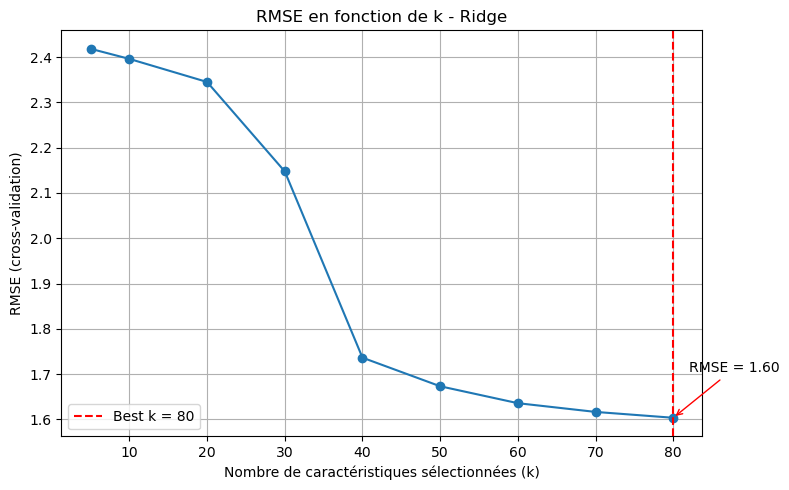

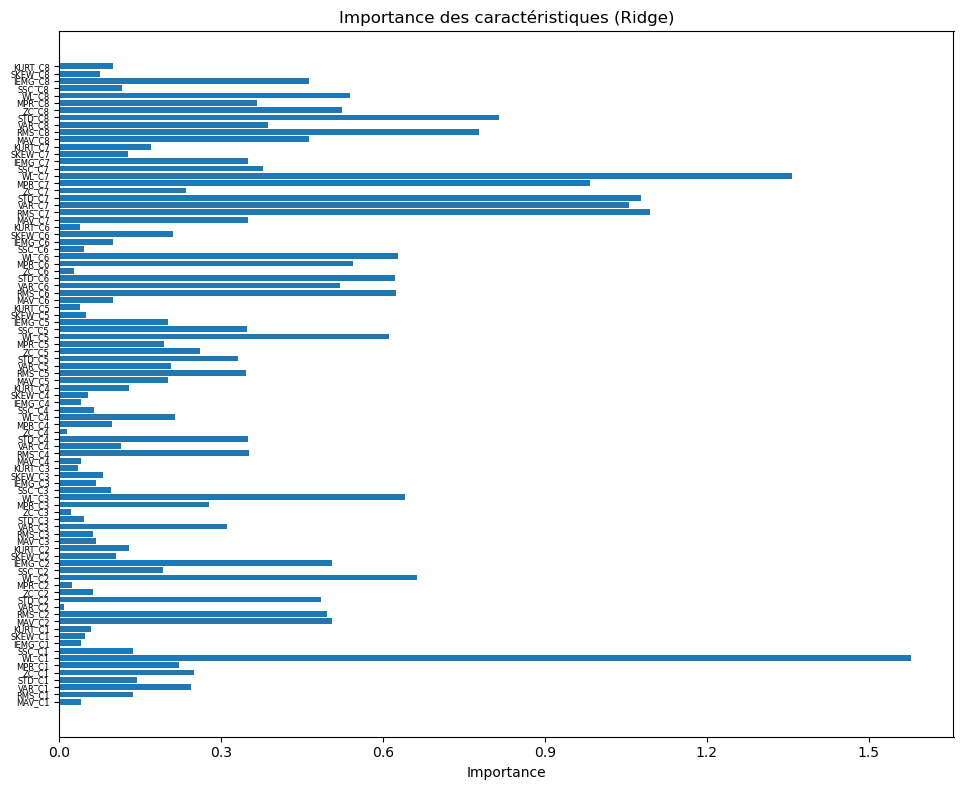

Shape des données en entrée du pipeline : (4595, 8, 500)

Caractéristiques sélectionnées pour le modèle SVR: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87]
Caractéristiques sélectionnées : ['MAV_C1', 'RMS_C1', 'VAR_C1', 'STD_C1', 'ZC_C1', 'MPR_C1', 'WL_C1', 'SSC_C1', 'IEMG_C1', 'SKEW_C1', 'KURT_C1', 'MAV_C2', 'RMS_C2', 'VAR_C2', 'STD_C2', 'ZC_C2', 'MPR_C2', 'WL_C2', 'SSC_C2', 'IEMG_C2', 'SKEW_C2', 'KURT_C2', 'MAV_C3', 'RMS_C3', 'VAR_C3', 'STD_C3', 'ZC_C3', 'MPR_C3', 'WL_C3', 'SSC_C3', 'IEMG_C3', 'SKEW_C3', 'KURT_C3', 'MAV_C4', 'RMS_C4', 'VAR_C4', 'STD_C4', 'ZC_C4', 'MPR_C4', 'WL_C4', 'SSC_C4', 'IEMG_C4', 'SKEW_C4', 'KURT_C4', 'MAV_C5', 'RMS_C5', 'VAR_C5', 'STD_C5', 'ZC_C5', 'MPR_C5', 'WL_C5', 'SSC_C5', 'IEMG_C5', 'SKEW_C5', 'KURT_C5', 'MAV_C6', 'RMS_C6', 'VAR_C6', 'ST

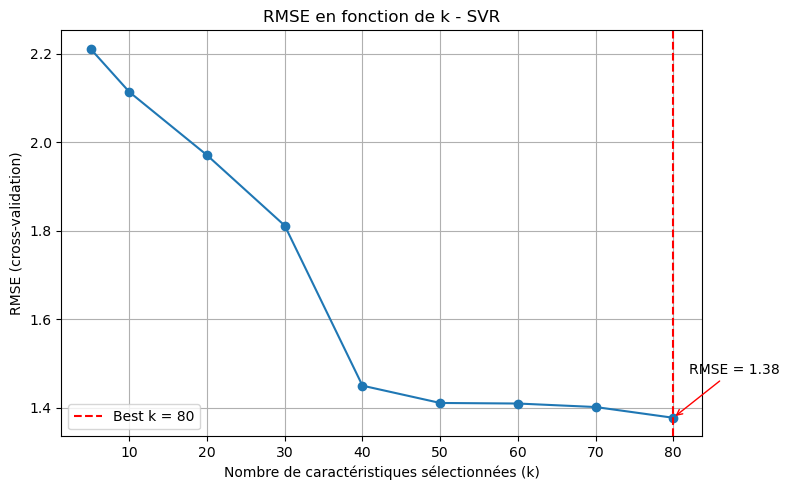

→ Pas d’importance directe des features pour SVR.
Shape des données en entrée du pipeline : (4595, 8, 500)

Caractéristiques sélectionnées pour le modèle RandomForest: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87]
Caractéristiques sélectionnées : ['MAV_C1', 'RMS_C1', 'VAR_C1', 'STD_C1', 'ZC_C1', 'MPR_C1', 'WL_C1', 'SSC_C1', 'IEMG_C1', 'SKEW_C1', 'KURT_C1', 'MAV_C2', 'RMS_C2', 'VAR_C2', 'STD_C2', 'ZC_C2', 'MPR_C2', 'WL_C2', 'SSC_C2', 'IEMG_C2', 'SKEW_C2', 'KURT_C2', 'MAV_C3', 'RMS_C3', 'VAR_C3', 'STD_C3', 'ZC_C3', 'MPR_C3', 'WL_C3', 'SSC_C3', 'IEMG_C3', 'SKEW_C3', 'KURT_C3', 'MAV_C4', 'RMS_C4', 'VAR_C4', 'STD_C4', 'ZC_C4', 'MPR_C4', 'WL_C4', 'SSC_C4', 'IEMG_C4', 'SKEW_C4', 'KURT_C4', 'MAV_C5', 'RMS_C5', 'VAR_C5', 'STD_C5', 'ZC_C5', 'MPR_C5', 'WL_C5', 'SSC_C5', 'IEMG_C

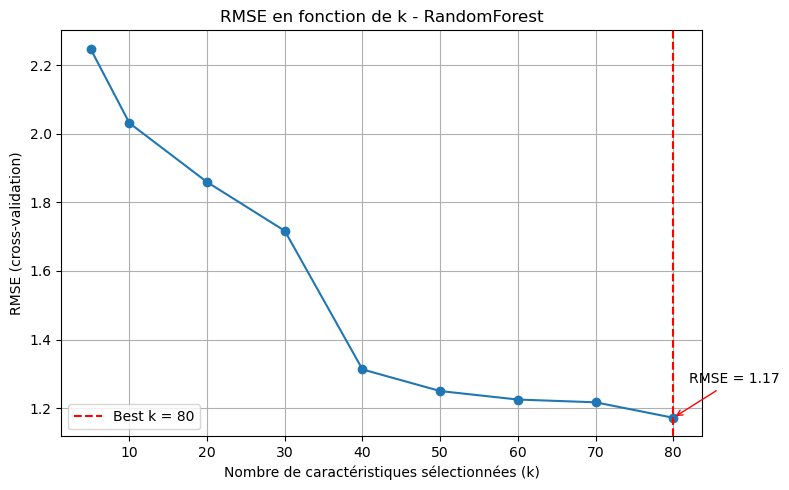

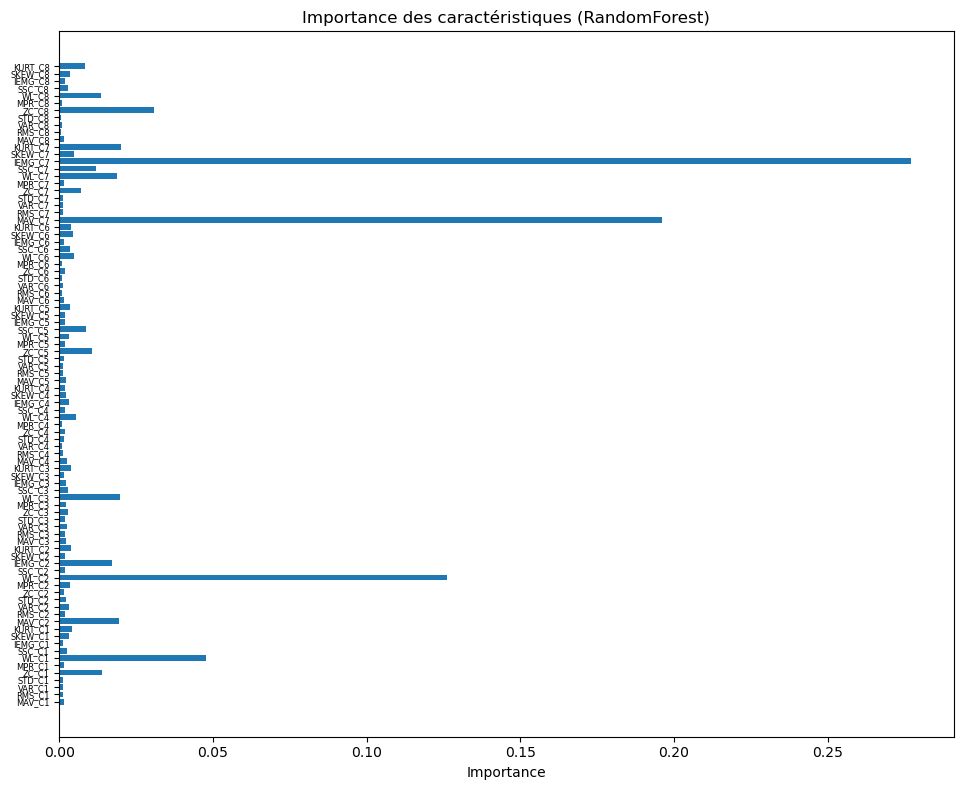

In [11]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    pipeline = Pipeline([
        ("features", FeatureExtractor()),
        ("scaler", StandardScaler()),
        ("selector", SelectKBest(score_func=f_regression, k='all')),  # Tester différentes valeurs pour k
        ("regressor", model)
    ])

    # Utilisation de GridSearchCV pour optimiser les hyperparamètres
    if name == "Ridge":
        grid_search = GridSearchCV(pipeline, param_grid_ridge, cv=kf, scoring='neg_mean_squared_error')
    elif name == "SVR":
        grid_search = GridSearchCV(pipeline, param_grid_svr, cv=kf, scoring='neg_mean_squared_error')
    else:
        grid_search = GridSearchCV(pipeline, {}, cv=kf, scoring='neg_mean_squared_error')

    grid_search.fit(X_vectorized, Y_vectorized[:, 0])  # On évalue la 1ʳᵉ articulation (colonne 0)
    print("Shape des données en entrée du pipeline :", X_vectorized.shape)

    best_model = grid_search.best_estimator_

    # 7. Visualisation des caractéristiques sélectionnées
    # Vérifier si SelectKBest a été utilisé dans le pipeline
    selector = best_model.named_steps.get('selector', None)
    if selector:
        selected_indices = selector.get_support(indices=True)
        print(f"\nCaractéristiques sélectionnées pour le modèle {name}: {selected_indices}")
    
        # Si tu veux les noms de features explicites (optionnel)
        stats = ["MAV", "RMS", "VAR", "STD", "ZC", "MPR", "WL", "SSC", "IEMG", "SKEW", "KURT"]
        channels = [f"C{i+1}" for i in range(8)]
        feature_names_full = [f"{stat}_{ch}" for ch in channels for stat in stats]
        feature_names = [feature_names_full[i] for i in selected_indices]
    
        print(f"Caractéristiques sélectionnées : {feature_names}")


    # Évaluation des résultats
    scores = -grid_search.best_score_  # Car 'neg_mean_squared_error' retourne les scores négatifs
    print(f"\nModèle : {name}")
    print(f"Meilleur RMSE trouvé (validation croisée) : {np.sqrt(scores):.4f}")
    print(f"Meilleur modèle : {best_model}")

    # Liste des k à tester
    k_values = [5, 10, 20, 30, 40, 50,60,70,80]
    rmse_by_k = {}
    
    print("\nÉvaluation des performances en fonction de k (sélection de caractéristiques) :")
    
    for k in k_values:
        pipeline.set_params(selector__k=k)
        grid_search = GridSearchCV(pipeline, {}, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_vectorized, Y_vectorized[:, 0])  # 1ʳᵉ articulation
        best_score = -grid_search.best_score_
        rmse = np.sqrt(best_score)
        rmse_by_k[k] = rmse
        print(f"k = {k:>2} | RMSE = {rmse:.4f}")

    best_k = min(rmse_by_k, key=rmse_by_k.get)
    best_rmse = rmse_by_k[best_k]

    plt.figure(figsize=(8, 5))
    plt.plot(list(rmse_by_k.keys()), list(rmse_by_k.values()), marker='o')
    plt.axvline(best_k, color='red', linestyle='--', label=f'Best k = {best_k}')
    plt.annotate(f"RMSE = {best_rmse:.2f}", xy=(best_k, best_rmse),
                 xytext=(best_k+2, best_rmse+0.1),
                 arrowprops=dict(arrowstyle="->", color='red'))
    plt.xlabel("Nombre de caractéristiques sélectionnées (k)")
    plt.ylabel("RMSE (cross-validation)")
    plt.title(f"RMSE en fonction de k - {name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    stats = ["MAV", "RMS", "VAR", "STD", "ZC", "MPR", "WL", "SSC", "IEMG", "SKEW", "KURT"]
    channels = [f"C{i+1}" for i in range(8)]
    feature_names_full = [f"{stat}_{ch}" for ch in channels for stat in stats]
    
    if name == "RandomForest":
        importances = best_model.named_steps['regressor'].feature_importances_
    
    elif name == "Ridge":
        # Attention : Ridge peut renvoyer 2D si multi-output. On prend ici la 1ʳᵉ articulation
        importances = np.abs(best_model.named_steps['regressor'].coef_.ravel())
    
    elif name == "SVR":
        # SVR n’a pas de feature_importance directe. On saute (ou utiliser permutation_importance si besoin)
        print("→ Pas d’importance directe des features pour SVR.")
        importances = None
    
    if importances is not None:
        plt.figure(figsize=(10, 8))
        plt.barh(feature_names_full, importances)
        plt.xlabel("Importance")
        plt.title(f"Importance des caractéristiques ({name})")
        plt.tight_layout()
        plt.gca().tick_params(axis='y', labelsize=2)  # 👈 réduit la taille des labels Y
        plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))  # contrôle nombre de ticks X
        plt.show()



In [ ]:
# X_test_windowed = overlap(X_guided_test)
# X_test_prepared = X_test_windowed.reshape(-1, 8, 500)
# X_test_features = best_model.named_steps['features'].transform(X_test_prepared)
# X_test_scaled = best_model.named_steps['scaler'].transform(X_test_features)
# X_test_selected = best_model.named_steps['selector'].transform(X_test_scaled)
# y_pred = best_model.named_steps['regressor'].predict(X_test_selected)

## ✅ Résultats
- Meilleur RMSE obtenu avec : SVR, `k = all (88)`
- Score RMSE moyen : `1.0885`

## 📊 Analyse des performances selon le nombre de caractéristiques (k)

Nous avons évalué l'impact du nombre de caractéristiques sélectionnées (`k`) sur les performances de trois modèles de régression : Ridge, SVR et RandomForest. Les données en entrée du pipeline sont de forme `(4595, 8, 500)`, soit 4595 fenêtres de 8 électrodes mesurées sur 500 points temporels. L'extracteur de caractéristiques génère un total de **88 features** (11 par électrode).

### ✅ Observation commune : le meilleur score est obtenu avec **toutes les caractéristiques**

Pour chaque modèle, nous avons testé une sélection croissante de caractéristiques (`k = 5, 10, ..., 80`). Voici les principaux constats :

---

### 🔷 Modèle : Ridge
- **RMSE minimum** : **1.5951** pour `k = 88` (toutes les features)
- RMSE croît nettement quand `k < 50`, indiquant que la réduction excessive des features nuit à la performance.
- Ce résultat montre que **Ridge profite de la régularisation L2** pour utiliser intelligemment toutes les variables, même en présence de redondance.

📌 **Conclusion** : *Pas d'overfitting observé* avec `k='all'`, la régularisation de Ridge est efficace pour absorber les corrélations entre features.

---

### 🔷 Modèle : SVR
- **RMSE minimum** : **1.0885** pour `k = 88`
- Le RMSE baisse progressivement avec `k`, mais reste toujours au-dessus du score complet tant que `k < 80`.
- Cela montre que **SVR tire parti de toutes les dimensions**, et que sa nature non-linéaire lui permet d'exploiter des combinaisons complexes de variables.

📌 **Conclusion** : *La performance du SVR est maximale avec toutes les features*. Réduire `k` réduit la capacité de modélisation non-linéaire.

---

### 🔷 Modèle : RandomForest
- **RMSE minimum** : **1.1668** pour `k = 88`
- Comme pour SVR, le RMSE diminue régulièrement avec l'ajout de features.
- Les arbres de décision du RandomForest profitent de la **diversité des features** pour mieux partitionner l’espace de décision.

📌 **Conclusion** : *RandomForest gère bien les données de grande dimension*, et **ne bénéficie pas** d'une sélection agressive de caractéristiques.

---

## 🧠 Décision finale

➡️ Pour **les trois modèles testés**, la **meilleure performance est atteinte sans réduction de dimension** (`k = 'all'`).

Cela suggère que :
- Les **features extraites sont pertinentes et non redondantes au point de nuire**.
- Les modèles utilisés (en particulier Ridge et RandomForest) **sont capables de traiter efficacement ces 88 dimensions**, grâce à la régularisation ou au découpage adaptatif (arbres).
- Il **n’est donc pas nécessaire de réduire `k`**, car cela **diminue systématiquement la performance**, avec des pertes de RMSE allant jusqu’à +1.3 sur Ridge.

✅ **Nous décidons donc de conserver toutes les caractéristiques extraites pour les prédictions finales.**

---
